In [588]:
import itertools
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from datetime import datetime
import random
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [589]:
dt = []
dt

[]

In [590]:
for i in range(0,1000):
 
    year = random.randint(2015, 2015)
    month = random.randint(1, 1)
    day = random.randint(1, 31)
    date1 = datetime(year, month, day)
    date1 = pd.to_datetime(date1)
    dt.append(date1)
dt[0:5], len(dt)

([Timestamp('2015-01-31 00:00:00'),
  Timestamp('2015-01-25 00:00:00'),
  Timestamp('2015-01-14 00:00:00'),
  Timestamp('2015-01-20 00:00:00'),
  Timestamp('2015-01-05 00:00:00')],
 1000)

In [591]:
index = random.sample(range(1000),1000)
vcounts = pd.DataFrame(index = index)
vcounts['video_id'] = np.random.randint(0,246,1000)
vcounts['view_count'] = np.random.randint(3000,20000,1000)
vcounts['date'] = dt
vcounts.head()

,video_id,view_count,date
981,232,10731,2015-01-31
80,130,4106,2015-01-25
702,197,5753,2015-01-14
632,25,12660,2015-01-20
807,98,12030,2015-01-05


In [592]:
dt2 = []
for i in range(0,1000):
 
    year = random.randint(2014, 2014)
    month = random.randint(12, 12)
    day = random.randint(1, 31)
    date2 = datetime(year, month, day)
    date2 = pd.to_datetime(date2)
    dt2.append(date2)
dt2[0:5], len(dt2)

([Timestamp('2014-12-29 00:00:00'),
  Timestamp('2014-12-24 00:00:00'),
  Timestamp('2014-12-26 00:00:00'),
  Timestamp('2014-12-23 00:00:00'),
  Timestamp('2014-12-14 00:00:00')],
 1000)

In [593]:
index2 = random.sample(range(1000),1000)
vfeatures = pd.DataFrame(index = index)
vfeatures['length'] = np.random.randint(100,1500,1000)
vfeatures['language'] = ['Es','Other','Fr','Gr'] * 250
vfeatures['upload_date'] = dt2
vfeatures['quality'] = ['240','1080','480','240','720'] * 200
vfeatures.head()

,length,language,upload_date,quality
981,700,Es,2014-12-29,240
80,1178,Other,2014-12-24,1080
702,907,Fr,2014-12-26,480
632,547,Gr,2014-12-23,240
807,458,Es,2014-12-14,720


In [594]:
def get_means(df):
    df = vcounts.groupby('video_id').describe(exclude=None).xs('mean',axis=1,level=1)
    return df.rename(columns = {'view_count': 'cnt_mean'})

def get_rch_means(df):
    df = vcounts.groupby(['video_id','date']).describe(exclude=None).groupby('video_id').\
pct_change().groupby('video_id').mean().\
xs('mean',axis=1,level=1)

    return df.rename(columns = {'view_count': 'rch_mean'})

def ext(df):
    
    df_means = get_means(df)
    
    df_rch_means= get_rch_means(df)
    
    return df_means.join(df_rch_means)


In [595]:
vstatistics = ext(vcounts)
vstatistics.head()

,cnt_mean,rch_mean
video_id,,
0,8257.0,-0.242308
1,4409.0,NaN
2,17212.0,0.124931
3,12199.4,-0.047181
4,16282.0,-0.320751


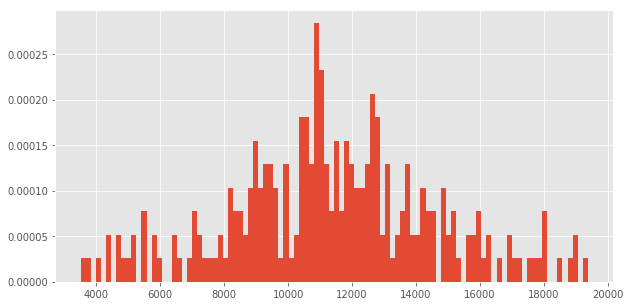

In [596]:
plt.figure(figsize=(10,5))
_ = plt.hist(vstatistics.cnt_mean,bins=100,normed=True)

In [597]:
cnt_cutoff = 14000
(vstatistics.cnt_mean >= cnt_cutoff).mean()

0.19672131147540983

In [598]:
vstatistics['is_popular'] = vstatistics.cnt_mean >= cnt_cutoff
vstatistics.head()

,cnt_mean,rch_mean,is_popular
video_id,,,
0,8257.0,-0.242308,False
1,4409.0,NaN,False
2,17212.0,0.124931,True
3,12199.4,-0.047181,False
4,16282.0,-0.320751,True


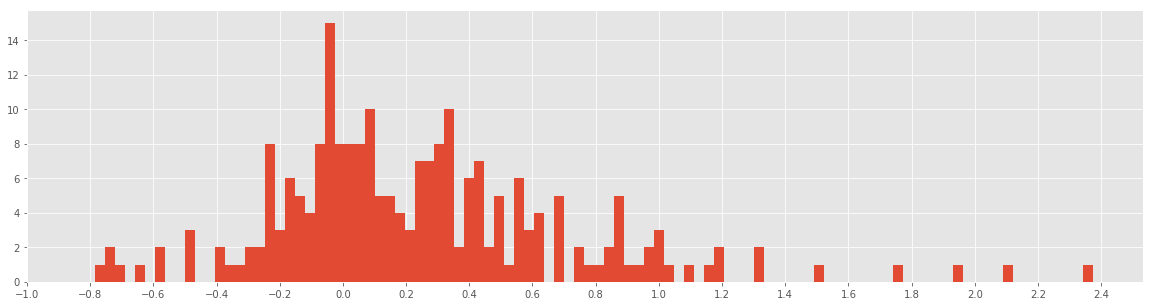

In [599]:
plt.figure(figsize=(20,5))
plt.hist(vstatistics.rch_mean.dropna(), bins = 100)
_ = plt.xticks(np.arange(-1,2.5,.2))

In [600]:
rch_bins = [-100,-.05,.05,100]
vstatistics['trend_status'] = pd.cut(vstatistics.rch_mean,rch_bins,right=False,labels=['decrease','flat','increase'])

In [601]:
vstatistics.trend_status.value_counts()

increase    133
decrease     54
flat         34
Name: trend_status, dtype: int64

In [602]:
videos = vfeatures
videos = videos.join(vstatistics.loc[:,['is_popular','trend_status']])

In [603]:
videos.sort_index().head()

,length,language,upload_date,quality,is_popular,trend_status
0,471,Fr,2014-12-15,720,False,decrease
1,581,Es,2014-12-12,240,False,NaN
2,888,Gr,2014-12-27,720,True,increase
3,340,Fr,2014-12-02,720,False,flat
4,1345,Other,2014-12-11,480,True,decrease


In [604]:
status = pd.Series('Everything else',index = videos.index)
status.loc[ videos.trend_status == 'increase'] = 'Hot'
status.loc[ (videos.trend_status == 'flat') & videos.is_popular] = 'Stable and Popular'

In [605]:
status

981       Everything else
80                    Hot
702       Everything else
632       Everything else
807       Everything else
516       Everything else
690       Everything else
325       Everything else
125                   Hot
921       Everything else
410       Everything else
116    Stable and Popular
785       Everything else
429       Everything else
553       Everything else
501       Everything else
265       Everything else
642       Everything else
490       Everything else
306       Everything else
356       Everything else
241                   Hot
543       Everything else
448       Everything else
365       Everything else
698       Everything else
484       Everything else
818       Everything else
546       Everything else
420       Everything else
              ...        
434       Everything else
517       Everything else
280       Everything else
405       Everything else
423       Everything else
194                   Hot
771       Everything else
507       Ev

In [606]:
status.value_counts()

Everything else       856
Hot                   133
Stable and Popular     11
dtype: int64

In [607]:
videos.groupby(status).apply(lambda df: df.shape[0])

Everything else       856
Hot                   133
Stable and Popular     11
dtype: int64

In [608]:
X = videos.copy()
X.head()

,length,language,upload_date,quality,is_popular,trend_status
981,700,Es,2014-12-29,240,NaN,NaN
80,1178,Other,2014-12-24,1080,False,increase
702,907,Fr,2014-12-26,480,NaN,NaN
632,547,Gr,2014-12-23,240,NaN,NaN
807,458,Es,2014-12-14,720,NaN,NaN


In [609]:
X['is_hot'] = (X.trend_status == 'increase').astype(int)
del X['is_popular']
del X['trend_status']

In [610]:

X['upload_weekday'] = X.upload_date.dt.weekday_name
del X['upload_date']

In [611]:

X.head()

,length,language,quality,is_hot,upload_weekday
981,700,Es,240,0,Monday
80,1178,Other,1080,1,Wednesday
702,907,Fr,480,0,Friday
632,547,Gr,240,0,Tuesday
807,458,Es,720,0,Sunday


In [612]:
weekday_hot = X.groupby(by='is_hot').apply(lambda df: df.upload_weekday.value_counts(normalize=True)).unstack()
weekday_hot

,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
is_hot,,,,,,,
0,0.118800,0.164937,0.123414,0.129181,0.136101,0.159170,0.168397
1,0.105263,0.165414,0.150376,0.082707,0.120301,0.210526,0.165414


In [613]:
weekday_hot.loc[:,["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]]

,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday
is_hot,,,,,,,
0,0.129181,0.164937,0.159170,0.168397,0.136101,0.118800,0.123414
1,0.082707,0.165414,0.210526,0.165414,0.120301,0.105263,0.150376


In [614]:
X.head()

,length,language,quality,is_hot,upload_weekday
981,700,Es,240,0,Monday
80,1178,Other,1080,1,Wednesday
702,907,Fr,480,0,Friday
632,547,Gr,240,0,Tuesday
807,458,Es,720,0,Sunday


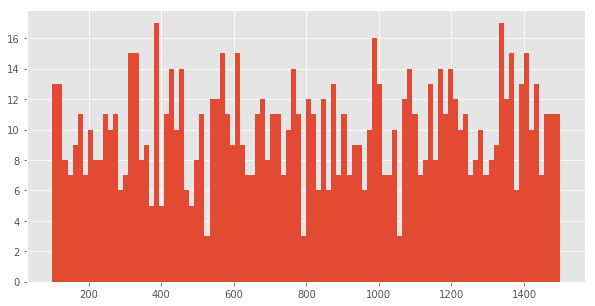

In [615]:
plt.figure(figsize = (10,5))
_ = plt.hist(X.length, bins = 100)

In [616]:
length_bins = [0,500,1000,1500]
X['length_bins'] = pd.cut(X.length,length_bins, right = False, labels = ['short','medium','long'])
length_hot = X.groupby('is_hot').apply(lambda df: df.length_bins.value_counts(normalize=True))
length_hot = length_hot.loc[:,['short','medium','long']]
length_hot

length_bins,short,medium,long
is_hot,,,
0,0.280277,0.349481,0.370242
1,0.285714,0.345865,0.368421


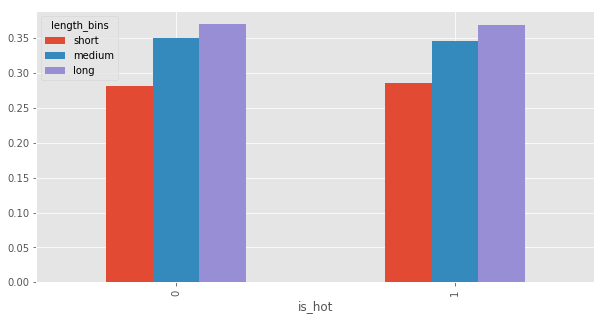

In [617]:
length_hot.plot(kind='bar',figsize=(10,5))

In [618]:
language_hot = X.groupby(by='is_hot').apply(lambda df: df.language.value_counts(normalize=True)).unstack()
language_hot

,Es,Fr,Gr,Other
is_hot,,,,
0,0.251442,0.245675,0.246828,0.256055
1,0.240602,0.278195,0.270677,0.210526


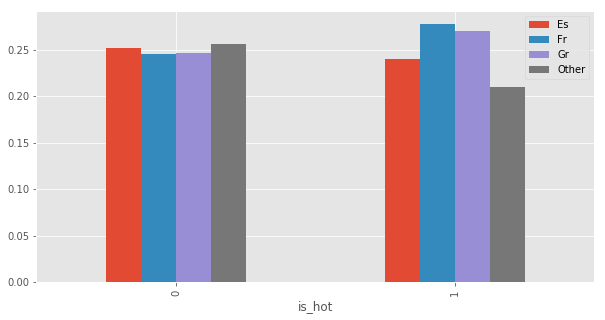

In [619]:
language_hot.plot(kind='bar',figsize=(10,5))

In [620]:
y = X.is_hot
del X['is_hot']
X = pd.get_dummies(X,columns=['language','upload_weekday', 'length_bins'],prefix='',prefix_sep='')

In [621]:
X.head()

,length,quality,Es,Fr,Gr,Other,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,short,medium,long
981,700,240,1,0,0,0,0,1,0,0,0,0,0,0,1,0
80,1178,1080,0,0,0,1,0,0,0,0,0,0,1,0,0,1
702,907,480,0,1,0,0,1,0,0,0,0,0,0,0,1,0
632,547,240,0,0,1,0,0,0,0,0,0,1,0,0,1,0
807,458,720,1,0,0,0,0,0,0,1,0,0,0,1,0,0


In [622]:
del X['Other']
X.head()

,length,quality,Es,Fr,Gr,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,short,medium,long
981,700,240,1,0,0,0,1,0,0,0,0,0,0,1,0
80,1178,1080,0,0,0,0,0,0,0,0,0,1,0,0,1
702,907,480,0,1,0,1,0,0,0,0,0,0,0,1,0
632,547,240,0,0,1,0,0,0,0,0,1,0,0,1,0
807,458,720,1,0,0,0,0,0,1,0,0,0,1,0,0


In [623]:
dt = DecisionTreeClassifier(max_depth = 4, min_samples_leaf = 20, min_samples_split = 20)
dt.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=20,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [624]:
feat_importances = pd.Series(dt.feature_importances_, index = X.columns)
feat_importances.sort_values(ascending = False, inplace = True)
feat_importances

length       0.588987
Sunday       0.126744
quality      0.111680
Wednesday    0.097788
Thursday     0.062135
medium       0.012667
long         0.000000
short        0.000000
Tuesday      0.000000
Saturday     0.000000
Monday       0.000000
Friday       0.000000
Gr           0.000000
Fr           0.000000
Es           0.000000
dtype: float64

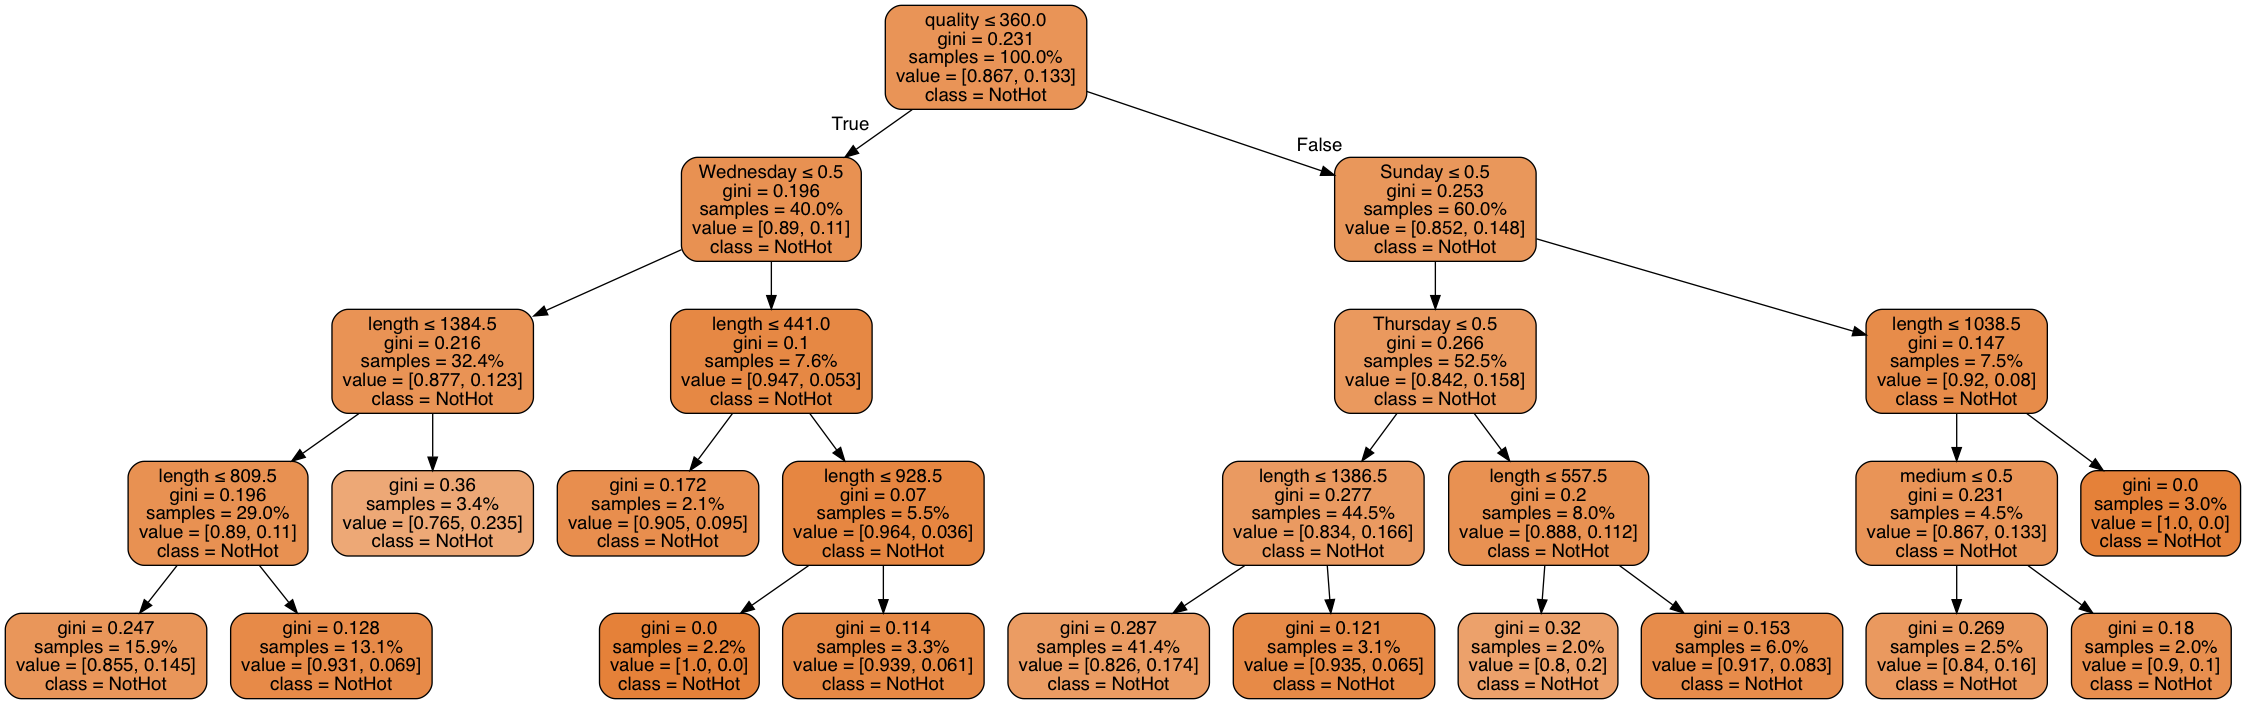

In [633]:
dot_data = StringIO()
export_graphviz(dt,rounded = True, class_names = ['NotHot','Hot'], proportion = True, feature_names = X.columns,filled=True, out_file = dot_data, special_characters = True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())